In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
print(torch.__version__)          # should show 2.0.1+cu117 or 2.0.1+cu118
print(torch.version.cuda)         # should show 11.7 or 11.8
print(torch.cuda.get_device_name(0))


/home/jorgen/classes/Masters/Network-Packet-ML-Model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.7.1+cu126
12.6
NVIDIA GeForce GTX 1080


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load network dataset
ds_train = load_dataset("rdpahalavan/network-packet-flow-header-payload", split="train")
ds_test = load_dataset("rdpahalavan/network-packet-flow-header-payload", split="test")

In [3]:
print(ds_train)
print(ds_train.features)

Dataset({
    features: ['packet_dat', 'attack_cat'],
    num_rows: 1187781
})
{'packet_dat': Value('string'), 'attack_cat': Value('string')}


In [4]:
sample = ds_train[0]   # first row
print(sample)
print(sample["packet_dat"])  # torch.Tensor
print(sample["attack_cat"])  # torch.Tensor

{'packet_dat': '0 0 141 -1 80 63713 2960 2920 64 0 5 0 -1 119 10 32 32 32 32 32 32 32 32 60 47 100 105 118 62 10 32 32 32 32 32 32 32 32 60 100 105 118 32 99 108 97 115 115 61 34 99 111 110 116 101 110 116 95 115 101 99 116 105 111 110 95 116 101 120 116 34 62 10 32 32 32 32 32 32 32 32 32 32 60 112 62 10 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 85 98 117 110 116 117 39 115 32 65 112 97 99 104 101 50 32 100 101 102 97 117 108 116 32 99 111 110 102 105 103 117 114 97 116 105 111 110 32 105 115 32 100 105 102 102 101 114 101 110 116 32 102 114 111 109 32 116 104 101 10 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 117 112 115 116 114 101 97 109 32 100 101 102 97 117 108 116 32 99 111 110 102 105 103 117 114 97 116 105 111 110 44 32 97 110 100 32 115 112 108 105 116 32 105 110 116 111 32 115 101 118 101 114 97 108 32 102 105 108 101 115 32 111 112 116 105 109 105 122 101 100 32 102 111 114 10 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 105 110 116 101 114 97 99 116 105 111 11

In [5]:
def get_label_categories(labels):
    counter = 0
    categories = {}
    for label in labels:
        if label not in categories:
            categories[label] = counter
            counter += 1
    return categories

In [6]:
categories = get_label_categories(ds_train["attack_cat"])
print(categories)

{'DDoS': 0, 'Normal': 1, 'DoS Hulk': 2, 'DoS': 3, 'Bot': 4, 'Exploits': 5, 'Fuzzers': 6, 'Reconnaissance': 7, 'Web Attack - XSS': 8, 'Heartbleed': 9, 'SSH Patator': 10, 'DoS SlowHTTPTest': 11, 'FTP Patator': 12, 'Generic': 13, 'Web Attack - Brute Force': 14, 'DoS GoldenEye': 15, 'Analysis': 16, 'Worms': 17, 'Infiltration': 18, 'DoS Slowloris': 19, 'Shellcode': 20, 'Backdoor': 21, 'Port Scan': 22, 'Web Attack - SQL Injection': 23}


In [7]:
# function to parse "packet_dat" string into a list of ints
def parse_packet(example):
    nums = list(map(int, example["packet_dat"].split()))
    return {"packet_tensor": torch.tensor(nums, dtype=torch.float), "attack_tensor": torch.tensor(categories[example["attack_cat"]], dtype=torch.int)}

In [8]:
# apply conversion
ds_train = ds_train.map(parse_packet)
ds_test = ds_test.map(parse_packet)

In [9]:
# now cast to torch
ds_train.set_format(type="torch", columns=["packet_tensor", "attack_tensor"], device=device)
ds_test.set_format(type="torch", columns=["packet_tensor", "attack_tensor"], device=device)

In [10]:
# teacher model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(513, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 24)
        )
    
    def forward(self, x):
        out = self.mlp(x)
        return out
    
# student model
class LightMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(513, 32)
        self.output = nn.Linear(32, 24)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        out = self.output(x)

        return out

In [11]:
# use with DataLoader
train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=32)

In [12]:
def train(model, train_loader, epochs, criterion, optimizer):

    train_loss = []

    model.train(True)
    
    for epoch in range(epochs):
        running_loss = 0.0

        for batch in train_loader:
            inputs = batch["packet_tensor"]   # tensor of shape [B, L]
            labels = batch["attack_tensor"]   # true attack category labels
            
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(inputs)
            loss = criterion(output, labels)
            running_loss += loss.item() * inputs.size(0)

            # Backward pass
            loss.backward()

            # Perform gradient clipping by value
            nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)

            # Update weights
            optimizer.step()

        # epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.2f}")
        
    return train_loss

In [13]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["packet_tensor"]   # tensor of shape [B, L]
            labels = batch["attack_tensor"]   # true attack category labels

            # Forward pass
            predicted = model(inputs)
            loss = criterion(predicted, labels)
            test_loss += loss.item() * inputs.size(0)

            # calculate accuracy
            total += labels.size(0)
            correct += (predicted.argmax(dim=1) == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {accuracy:.2f}")
    return accuracy

In [14]:
torch.manual_seed(42)
teacher_model = MLP().to(device)
teacher_criterion = nn.CrossEntropyLoss()
teacher_optimizer = torch.optim.SGD(teacher_model.parameters(), lr=0.0001)
train_loss = train(teacher_model, train_loader, epochs=3, criterion=teacher_criterion, optimizer=teacher_optimizer)
test_accuracy = test(teacher_model, test_loader, criterion=teacher_criterion)

Epoch: 1/3, Loss: 19.61
Epoch: 2/3, Loss: 15.29
Epoch: 3/3, Loss: 7.86
Test Loss: 6061895.33, Test Accuracy: 83.31


In [15]:
torch.manual_seed(42)
student_model = LightMLP().to(device)
student_criterion = nn.CrossEntropyLoss()
student_optimizer = torch.optim.SGD(student_model.parameters(), lr=0.0001)
train_loss_student = train(student_model, train_loader, epochs=3, criterion=student_criterion, optimizer=student_optimizer)
test_accuracy_student = test(student_model, test_loader, criterion=student_criterion)

Epoch: 1/3, Loss: 397.72
Epoch: 2/3, Loss: 115.41
Epoch: 3/3, Loss: 38.80
Test Loss: 6023206.74, Test Accuracy: 77.59


In [16]:
torch.manual_seed(42)
new_student_model = LightMLP().to(device)
new_student_criterion = nn.CrossEntropyLoss()
new_student_optimizer = torch.optim.SGD(new_student_model.parameters(), lr=0.0001)

In [17]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, ce_loss, optimizer, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75):
    teacher.eval()
    student.train()
    train_loss = []

    for epoch in range(epochs):
        running_loss = 0.0
        
        for batch in train_loader:
            inputs = batch["packet_tensor"]   # tensor of shape [B, L]
            labels = batch["attack_tensor"]   # true attack category labels

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(
                soft_targets * ((soft_targets + 1e-8).log() - soft_prob)
            ) / soft_prob.size(0) * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)
            
            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
            running_loss += loss.item()
            loss.backward()

            # Perform gradient clipping by value
            nn.utils.clip_grad_value_(student.parameters(), clip_value=0.2)

            optimizer.step()
        
        # epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)

        print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.2f}")
    
    return train_loss

    

In [18]:
new_student_loss = train_knowledge_distillation(teacher=teacher_model, student=new_student_model, train_loader=train_loader, epochs=3, optimizer=new_student_optimizer, ce_loss=new_student_criterion)

Epoch: 1/3, Loss: 7.03
Epoch: 2/3, Loss: 3.59
Epoch: 3/3, Loss: 2.81


In [19]:
test_accuracy_new_student = test(new_student_model, test_loader, new_student_criterion)

Test Loss: 33992123.78, Test Accuracy: 70.52


In [23]:
def plot_loss(loss_list, n_epochs, model_name):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    plt.plot(epochs, loss_list, marker="+", linestyle="dotted")
    plt.title(f"Model: {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


In [25]:
def plot_accuracy(acc_list, model_names):
    plt.bar(model_names, acc_list)
    plt.title("Model accurecies")
    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.show()

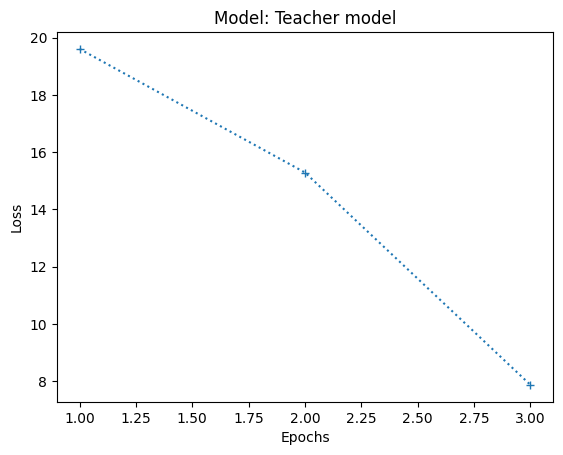

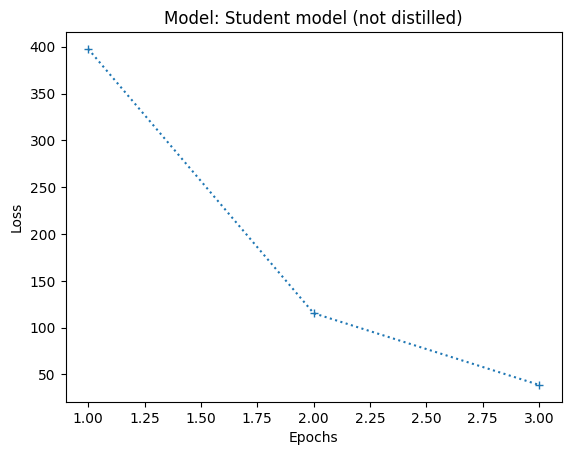

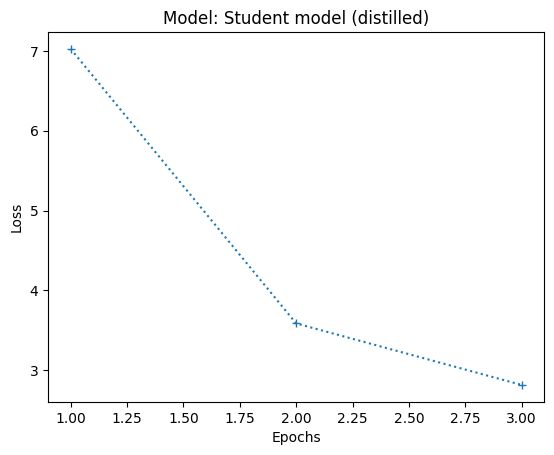

In [24]:
# plot loss for each model
plot_loss(train_loss, n_epochs=len(train_loss), model_name="Teacher model")
plot_loss(train_loss_student, n_epochs=len(train_loss_student), model_name="Student model (not distilled)")
plot_loss(new_student_loss, n_epochs=len(new_student_loss), model_name="Student model (distilled)")

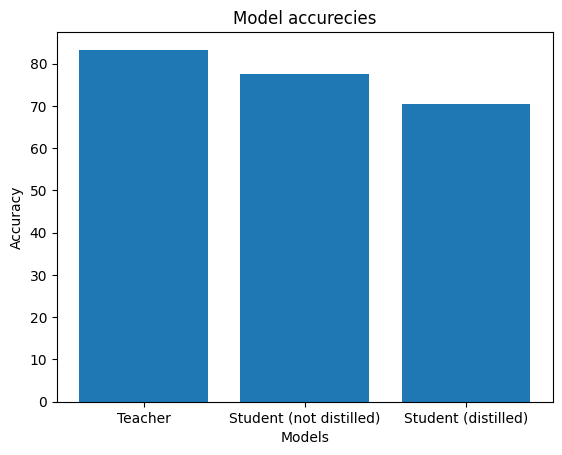

In [29]:
plot_accuracy(acc_list=[test_accuracy, test_accuracy_student, test_accuracy_new_student], model_names=["Teacher", "Student (not distilled)", "Student (distilled)"])

In [28]:
checkpoint_path = "/home/jorgen/classes/Masters/Network-Packet-ML-Model/checkpoint/checkpoint.pth"

checkpoint = {
    "epoch": len(new_student_loss),
    "model_state_dict": new_student_model.state_dict(),
    "optimizer_state_dict": new_student_optimizer.state_dict()
}
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved at {checkpoint_path}")



Checkpoint saved at /home/jorgen/classes/Masters/Network-Packet-ML-Model/checkpoint/checkpoint.pth
